In [ ]:
# https://github.com/ml4a/ml4a-guides/blob/master/notebooks/image-search.ipynb

In [2]:
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

def get_session(gpu_fraction=1):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

KTF.set_session(get_session())

Using TensorFlow backend.


In [3]:
import pandas as pd
import numpy as np

In [4]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Dense, concatenate
from keras.utils.vis_utils import plot_model
from IPython.display import Image
from tqdm import tqdm

In [5]:
raw = raw.loc[:,['buyer','product','created']]
raw['created'] = pd.to_datetime(raw.created)
raw['created'] = [x.month for x in raw['created']]
raw.columns = ['user','item','month']
raw.shape

(243169, 3)

In [6]:
item_index = raw.groupby(['item'])['month'].agg([('quantity_sum', 'count')])

In [7]:
item_index = item_index.loc[item_index['quantity_sum']>=5]

In [8]:
len(item_index)

11787

In [9]:
product_RFM = pd.read_csv('../productRFM_RANK_ALL.csv')

In [10]:
product_RFM = product_RFM[['product', 'recency.1', 'freq.1', 'amount.1']]

In [11]:
product_RFM.columns = ['item','item_F','item_M','item_R']
product_RFM.head()

,item,item_F,item_M,item_R
0,102870,0.114754,0.000000,0.000390
1,108733,0.278689,0.000000,0.000683
2,109660,0.295082,0.000000,0.001269
3,109661,0.316940,0.029762,0.004588
4,109662,0.158470,0.000000,0.001757


In [12]:
product_category_data = pd.read_csv('product_category_data.csv')
product_category_data.head()

,item,cate_1,cate_2,cate_3
0,102870,70.0,36.0,100.0
1,108733,8.0,36.0,100.0
2,109660,8.0,107.0,26.0
3,109661,8.0,107.0,26.0
4,109662,8.0,107.0,26.0


In [13]:
item_index = item_index.drop(['quantity_sum'], axis=1)

In [14]:
item_index = item_index.merge(product_RFM, how="left", on= "item")

In [15]:
item_index = item_index.merge(product_category_data, how="left", on= "item")

In [16]:
item_index.head()

,item,item_F,item_M,item_R,cate_1,cate_2,cate_3
0,109661,0.316940,0.029762,0.004588,8.0,107.0,26.0
1,203919,0.568306,0.047619,0.008688,70.0,36.0,43.0
2,205371,0.622951,0.059524,0.009274,70.0,107.0,88.0
3,215700,0.125683,0.023810,0.004686,70.0,100.0,0.0
4,269577,0.306011,0.029762,0.014545,60.0,81.0,0.0


In [17]:
factors = 10

In [18]:
vgg16 = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [19]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [20]:
cnn_input = Input(shape=(224,224,3),name = 'image_input')
image_cnn = vgg16(cnn_input)
cnn_flatten = Flatten(name='flatten')(image_cnn)
cnn_dense1 = Dense(4096, activation='relu', name='fc1')(cnn_flatten)
cnn_dense2 = Dense(4096, activation='relu', name='fc2')(cnn_dense1)


item_R_input = Input(shape=[1], name='item_R')
item_R_dense1 = Dense(512, activation='relu')(item_R_input)
item_R_dense2 = Dense(256, activation='relu')(item_R_dense1)
item_R_out = Dense(factors, activation='relu')(item_R_dense2)

item_F_input = Input(shape=[1], name='item_F')
item_F_dense1 = Dense(512, activation='relu')(item_F_input)
item_F_dense2 = Dense(256, activation='relu')(item_F_dense1)
item_F_out = Dense(factors, activation='relu')(item_F_dense2)

item_M_input = Input(shape=[1], name='item_M')
item_M_dense1 = Dense(512, activation='relu')(item_M_input)
item_M_dense2 = Dense(256, activation='relu')(item_M_dense1)
item_M_out = Dense(factors, activation='relu')(item_M_dense2)

cate_1_input = Input(shape=[1], name='cate_1')
cate_1_dense1 = Dense(512, activation='relu')(cate_1_input)
cate_1_dense2 = Dense(256, activation='relu')(cate_1_dense1)
cate_1_out = Dense(factors, activation='relu')(cate_1_dense2)


cate_2_input = Input(shape=[1], name='cate_2')
cate_2_dense1 = Dense(512, activation='relu')(cate_2_input)
cate_2_dense2 = Dense(256, activation='relu')(cate_2_dense1)
cate_2_out = Dense(factors, activation='relu')(cate_2_dense2)


cate_3_input = Input(shape=[1], name='cate_3')
cate_3_dense1 = Dense(512, activation='relu')(cate_3_input)
cate_3_dense2 = Dense(256, activation='relu')(cate_3_dense1)
cate_3_out = Dense(factors, activation='relu')(cate_3_dense2)


merge_item = concatenate([cnn_dense2, item_R_out, item_F_out, item_M_out, cate_1_out, cate_2_out, cate_3_out])



#out = Dense(1, activation='sigmoid')(merge_item)

model = Model(inputs= [cnn_input, item_R_input, item_F_input, item_M_input, cate_1_input, cate_2_input, cate_3_input], output= merge_item)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("co...)`


In [21]:
model.summary()
plot_model(model, show_shapes=True)
Image('model.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 7, 7, 512)    14714688    image_input[0][0]                
__________________________________________________________________________________________________
item_R (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
item_F (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
item_M (In

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [22]:
directory = "../../linkshops.full.5.img/"
path = directory+str(item_index.item[0])+".jpg"

In [23]:
path

'../../linkshops.full.5.img/109661.jpg'

In [24]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

def load_photos_predict(directory):
    images = []
    for name in tqdm(listdir(directory)):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = np.expand_dims(image, axis=0)
        # prepare the image for the  model
        image = preprocess_input(image)
        # get image id
        image_id = name.split('.')[0]
        item_data = item_index.loc[item_index['item'] == int(image_id)]
        feature = model.predict([image, item_data.item_F, item_data.item_R, item_data.item_M,
                                item_data.cate_1, item_data.cate_2, item_data.cate_3]).ravel()
        images.append((image_id, image, feature))
    return images

In [25]:
images = load_photos_predict(directory)

100%|██████████| 11787/11787 [15:18<00:00, 13.05it/s]


In [26]:
len(images)

11787

In [27]:
aa = pd.DataFrame(images)

In [28]:
aa.columns = ['item', 'image', 'features']

In [29]:
aa.head()

,item,image,features
0,1161256,"[[[[0.7019608 0.6784314 0.6392157], [0.7176471...","[0.4604829, 0.0, 0.0, 0.11043884, 0.16306031, ..."
1,1241998,"[[[[0.88235295 0.8509804 0.827451 ], [0.8901...","[1.1079718, 0.0, 0.0, 0.0, 0.63224906, 0.0, 0...."
2,1079650,"[[[[0.17647064 0.16078436 0.06666672], [ 0.011...","[0.09855065, 0.0, 0.0, 0.039675683, 1.0326931,..."
3,848779,"[[[[0.36470592 0.24705887 0.09803927], [0.3882...","[0.88531685, 0.0, 0.0, 0.0, 1.0173731, 0.0, 0...."
4,1340332,"[[[[0.20000005 0.16078436 0.11372554], [0.2000...","[0.4965982, 0.0, 0.0, 0.0, 0.46818516, 0.0, 0...."


In [30]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy
nn_num = 6
X = list(aa['features'])
nbrs = NearestNeighbors(n_neighbors=nn_num, algorithm= 'ball_tree', 
                        metric="euclidean", n_jobs = -1).fit(X)

In [31]:
bb = np.array(aa['features'])

In [32]:
dd = []
for i in range(len(bb)):
    new = np.reshape(bb[i], (1, -1))
    dd.append(new)

In [33]:
aa['features'] = dd

In [34]:
aa = aa.reset_index()

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def udfsimular(indices, table):
    neighbours = []
    for i in range(len(indices)): 
        t = indices[i]
        idv = table[(table.index == t)].iloc[0]['item']
        neighbours.append(idv)
    return neighbours

def udfidfpathh(ids,directory):
    paths = []
    for i in range(len(ids)): 
        t = ids[i]
        filename = directory + t + '.jpg'
        paths.append(filename)
    return paths

def show5recommendations(name, table, NearestN,  idnr, directory, columnfeature):
    key = table[(table.item == idnr)].iloc[0][columnfeature]
    distances, indices = NearestN.kneighbors(key)
    listindices = pd.DataFrame(indices).values.tolist()
    listindices2 = listindices[0]
    ids = udfsimular(listindices2, table)
    paths2 = udfidfpathh(ids,directory)
    fig, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(nrows=1, ncols=6, sharex=True, sharey=True, figsize=(14,3))
    # Doing each of these manually (ugh)
    ax1.imshow(mpimg.imread(paths2[0]))
    ax1.set_title(r"$\bf{" + str(name) + "}$"+"\n Targer:\n"+ ids[0])
    ax1.set_yticklabels([])
    ax2.imshow(mpimg.imread(paths2[1]))
    ax2.set_title("Rec 1:\n"+ ids[1])
    ax3.imshow(mpimg.imread(paths2[2]))
    ax3.set_title("Rec 2:\n"+ ids[2])
    ax4.imshow(mpimg.imread(paths2[3]))
    ax4.set_title("Rec 3:\n"+ ids[3])
    ax5.imshow(mpimg.imread(paths2[4]))
    ax5.set_title("Rec 4:\n"+ ids[4])
    ax6.imshow(mpimg.imread(paths2[5]))
    ax6.set_title("Rec 5:\n"+ ids[5])

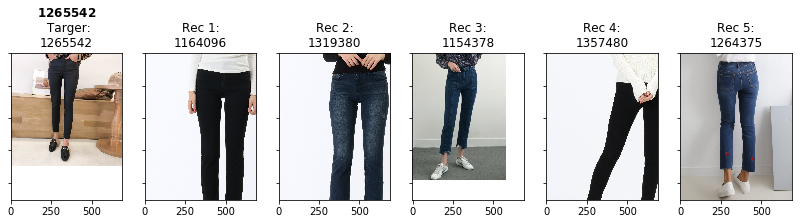

In [36]:
show5recommendations(aa['item'][7949] , aa, nbrs, aa['item'][7949], '../../linkshops.full.5.img/', 'features')

In [37]:
item_index.loc[[7949]]

,item,item_F,item_M,item_R,cate_1,cate_2,cate_3
7949,1296103,0.945355,0.077381,0.024795,70.0,107.0,52.0


In [38]:
item_index.loc[item_index['item']== 1319380]

,item,item_F,item_M,item_R,cate_1,cate_2,cate_3
8625,1319380,0.934426,0.047619,0.018157,70.0,107.0,88.0


In [39]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [40]:
images_path = '../../linkshops.full.5.img/'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = len(item_index)

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 11787 images to analyze


In [41]:
import time
tic = time.clock()


features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    img, x = load_image(image_path);
    feat = model.predict([x, item_index.item_F, item_index.item_R, item_index.item_M, item_index.cate_1, item_index.cate_2, item_index.cate_3])[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 11787. Time: 0.0001 seconds.
analyzing image 500 / 11787. Time: 30.5502 seconds.
analyzing image 1000 / 11787. Time: 28.5286 seconds.
analyzing image 1500 / 11787. Time: 30.7507 seconds.
analyzing image 2000 / 11787. Time: 26.8137 seconds.
analyzing image 2500 / 11787. Time: 25.5014 seconds.
analyzing image 3000 / 11787. Time: 26.9331 seconds.
analyzing image 3500 / 11787. Time: 27.8573 seconds.
analyzing image 4000 / 11787. Time: 29.2671 seconds.
analyzing image 4500 / 11787. Time: 26.1599 seconds.
analyzing image 5000 / 11787. Time: 27.9274 seconds.
analyzing image 5500 / 11787. Time: 25.5828 seconds.
analyzing image 6000 / 11787. Time: 28.8185 seconds.
analyzing image 6500 / 11787. Time: 26.8488 seconds.
analyzing image 7000 / 11787. Time: 26.7696 seconds.
analyzing image 7500 / 11787. Time: 27.8789 seconds.
analyzing image 8000 / 11787. Time: 26.3293 seconds.
analyzing image 8500 / 11787. Time: 27.7090 seconds.
analyzing image 9000 / 11787. Time: 26.7424 seconds

In [42]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=1000)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=1000, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [43]:
pca_features = pca.transform(features)

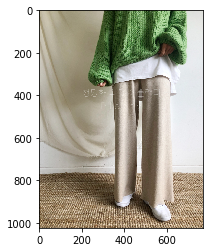

In [44]:
import random

# grab a random query image
query_image_idx = int(len(images) * random.random())

# let's display the image
img = image.load_img(images[query_image_idx])
plt.imshow(img)

In [45]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

In [46]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:11]

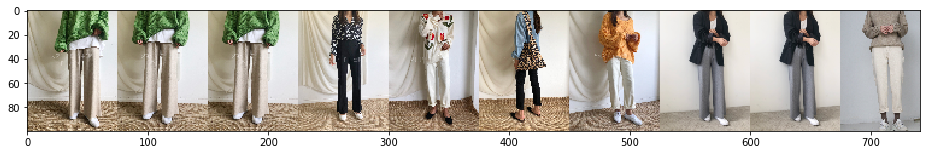

In [47]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

In [48]:
def get_closest_images(query_image_idx, num_results=10):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5, 1.0, 'result images')

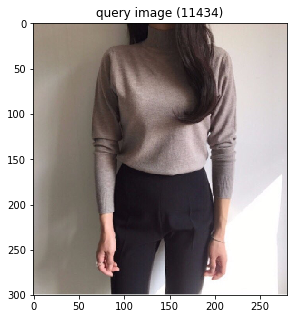

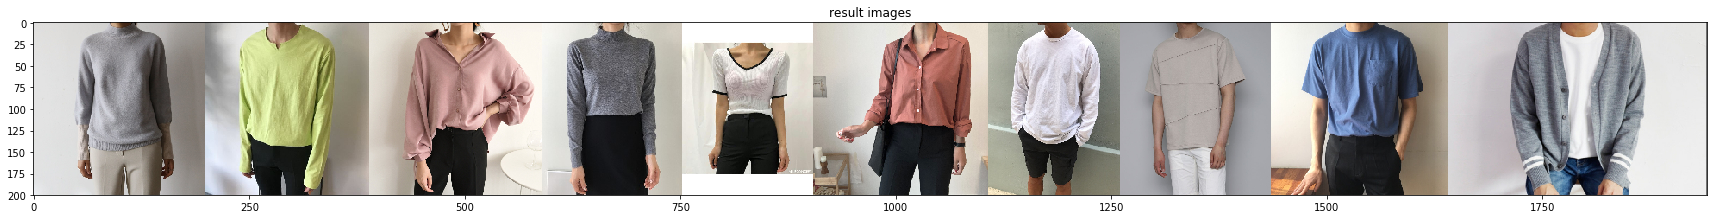

In [49]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (30,30))
plt.imshow(results_image)
plt.title("result images")

In [50]:
query_image_idx

11434

In [51]:
idx_closest

[2889, 1309, 2313, 9734, 5612, 8245, 1525, 3432, 6298, 239]

In [52]:
item_index.loc[[query_image_idx]]

,item,item_F,item_M,item_R,cate_1,cate_2,cate_3
11434,1438430,0.967213,0.035714,0.084635,70.0,67.0,101.0


In [53]:
item_index.loc[idx_closest]

,item,item_F,item_M,item_R,cate_1,cate_2,cate_3
2889,1095283,0.327869,0.071429,0.016302,70.0,36.0,100.0
1309,933635,0.480874,0.047619,0.026259,8.0,107.0,88.0
2313,1052048,0.639344,0.148810,0.045002,100.0,0.0,0.0
9734,1355740,0.852459,0.047619,0.018450,70.0,67.0,80.0
5612,1202416,0.519126,0.029762,0.005759,70.0,77.0,78.0
8245,1307432,0.792350,0.077381,0.034752,70.0,67.0,101.0
1525,965308,0.136612,0.029762,0.006052,70.0,36.0,100.0
3432,1136221,0.551913,0.053571,0.009567,70.0,36.0,100.0
6298,1231095,0.743169,0.035714,0.008102,70.0,36.0,10.0
239,617564,0.726776,0.083333,0.033581,72.0,0.0,0.0


In [107]:
raw = pd.read_csv('../../csv_data/linkshops.order.csv')

In [108]:
raw = raw.loc[:,['buyer','product','created']]
raw['created'] = pd.to_datetime(raw.created)
raw['created'] = [x.month for x in raw['created']]
raw.columns = ['user','item','month']
print(raw.shape)
raw.head()

(243169, 3)


,user,item,month
0,34990,1047047,7
1,54804,940522,7
2,54804,1029752,7
3,54804,1045597,7
4,54804,1066000,7


In [109]:
order = pd.read_csv('../../csv_data/linkshops.order.csv')

In [110]:
ord_count = order.groupby(["product"])["orddtl"].agg([("ord_count", "count")]).reset_index()

In [111]:
ord_count = ord_count[ord_count["ord_count"] >= 5].reset_index(drop=True)

In [112]:
order_copy = order

In [113]:
item_list = list(ord_count['product'])

In [114]:
order_tmp = raw[raw.item.isin(item_list)]

In [115]:
order_tmp = order_tmp.reset_index(drop=True)

In [116]:
order_tmp = order_tmp.drop_duplicates()

In [117]:
order_tmp

,user,item,month
0,54804,1045597,7
1,50871,950587,7
2,26005,918665,7
4,26330,900784,7
5,26330,886992,7
6,26330,917758,7
7,26330,986791,7
9,26330,1065039,7
10,26330,1070036,7
12,26330,806265,7


In [118]:
train = order_tmp[order_tmp.month==(7)].drop('month',axis=1)
test = order_tmp[((order_tmp.month==(9))|(order_tmp.month==(9))|(order_tmp.month==(10))|(order_tmp.month==(11))|(order_tmp.month==(12)))].drop('month',axis=1)

In [119]:
same_user = []
for i in train.user.unique():
    for j in test.user.unique():
        if i == j :
            same_user.append(i)

In [120]:
len(same_user)

1144

In [121]:
train = train[train.user.isin(same_user)]
train = train.reset_index(drop=True)

In [122]:
train = train.groupby('user').last().reset_index()

In [123]:
train

,user,item
0,7613,1072838
1,7616,1102073
2,8209,963008
3,8507,1095565
4,9152,1093180
5,10012,1032268
6,10049,965026
7,10239,988183
8,10700,1001505
9,10951,870294


In [175]:
id_list = []
item_list = []
for i in tqdm(range(len(train))):
    user_id = train.user[i]
    item_id = train.item[i]
    query_image_idx = item_index.loc[item_index['item'] == item_id].index
    idx_closest = get_closest_images(query_image_idx)
    for j in range(10):
        index_num = item_index.loc[item_index.index == idx_closest[j]].index[0]
        item_list.append(item_index['item'][index_num])
        id_list.append(user_id)

100%|██████████| 1144/1144 [16:08<00:00,  1.17it/s]


In [179]:
len(id_list)

11440

In [180]:
len(item_list)

11440

In [181]:
asd = pd.DataFrame(item_list, id_list).reset_index()
asd.columns=['user', 'item']

In [182]:
asd

,user,item
0,7613,1230210
1,7613,999994
2,7613,997391
3,7613,1353376
4,7613,1213390
5,7613,1148230
6,7613,1194972
7,7613,1303512
8,7613,1321664
9,7613,1439464
